# Hands-on Lab: Cats vs Dogs Image Classifiers

Welcome to the hands-on lab! You will be using the famous `Cats vs Dogs` dataset to train a model that can classify images of dogs from images of cats. For this, you will create your own Convolutional Neural Network in Tensorflow and leverage Keras image preprocessing utilities.

You will also create some helper functions to move the images around the filesystem so if you are not familiar with the `os` module be sure to take a look a the [docs](https://docs.python.org/3/library/os.html).

Let's get started!

In [28]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from matplotlib import image
import cv2
import numpy as np
from sklearn.model_selection import train_test_split 

Download the dataset from its original source by running the cell below. 

Note that the `zip` file that contains the images is unzipped under the `/tmp` directory.

In [2]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-02-02 18:30:53--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.252.210
Connecting to download.microsoft.com (download.microsoft.com)|23.36.252.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  4.61MB/s    in 2m 58s  

2023-02-02 18:33:52 (4.41 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [3]:
# source_path = '/tmp/PetImages'
source_path = '/Users/mdaniyalk/Documents/github/learn/image-processing-gdsc-ugm/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

find: /tmp/PetImages/: No such file or directory
There are 12500 images of dogs.
There are 12500 images of cats.


In [3]:
def preview_sample(SOURCE_DIR, NUM_OF_IMGS):
  """
  Preview sample images from directories
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    NUM_OF_IMGS (int): number sample of images to preview
    
  Returns:
    None
  """
  for i in range(NUM_OF_IMGS):
    img_class = random.choice(['Cat', 'Dog'])
    folder_path = os.path.join(SOURCE_DIR, img_class)
    img_path = os.listdir(folder_path)
    img = image.imread(os.path.join(folder_path, random.choice(img_path)))
    plt.imshow(img)
    plt.show()


Displaying 5 random sample images from dataset

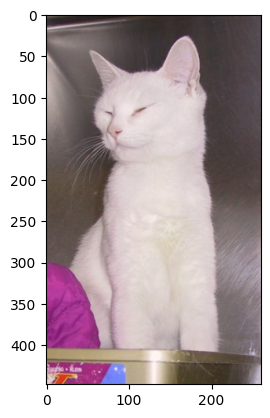

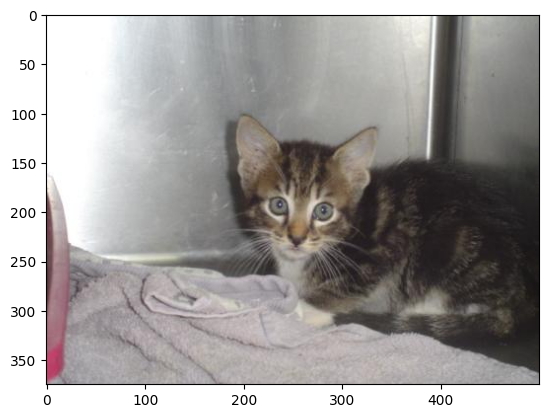

In [4]:
preview_sample(source_path, 2)

Read Images and it's labels

In [21]:
def load_dataset(SOURCE_DIR, CLASS_NAME, TARGET_SIZE):
  """
  Load images and labels from directories
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    CLASS_NAME (array_like): Array of class names
    TARGET_SIZE (array_like): Dimension of the images
    
  Returns:
    array_like: Images data
    array_like: Images label
  """

  dataset = []
  label = []

  for _class in CLASS_NAME:
    tmp_dataset = []
    folder_path = os.path.join(SOURCE_DIR, _class)
    for img_file in os.listdir(folder_path):
      tmp_data = cv2.imread(os.path.join(folder_path, img_file))
      if tmp_data is not None:
        tmp_data = cv2.resize(tmp_data, dsize=TARGET_SIZE, interpolation=cv2.INTER_AREA)
        tmp_dataset.append(tmp_data)
        label.append(_class)
    dataset.append(np.asarray(tmp_dataset))
  dataset = np.concatenate(dataset, axis=0)
  
  # Label converter
  labels = []
  for _label in label:
    labels.append(CLASS_NAME.index(_label))
    
  # One hot encoder for multiple classes
  if len(CLASS_NAME) > 2:
    labels = tf.keras.utils.to_categorical(labels).astype(int)
  del label

  return dataset, np.asarray(labels)

In [22]:
class_name = ['Cat', 'Dog']
dataset, labels = load_dataset(source_path, class_name, (150,150))

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


In [27]:
# Checking dataset and labels shape
print(dataset.shape)
print(labels.shape)

(24946, 150, 150, 3)
(24946,)


In [29]:
# Train test split
train_data, test_data, label_train, label_test = train_test_split(dataset, labels, train_size=0.8, shuffle=True)

In [30]:
# Checking train, test, and it's label shape
print(train_data.shape)
print(label_train.shape)
print(test_data.shape)
print(label_test.shape)

(19956, 150, 150, 3)
(19956,)
(4990, 150, 150, 3)
(4990,)


Defining the CNN Model

In [43]:
def create_model():

  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(), # Uncomment to use BatchNormalization
      tf.keras.layers.GlobalAveragePooling2D(),
      # tf.keras.layers.Flatten(), # If you use GlobalAveragePooling, comment this line
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.5), # Uncomment to use dropout
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
    

  return model


In [44]:
# Get the untrained model
model = create_model()

In [45]:
# Display model architecture
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 17, 17, 64)      

In [46]:
# Train the model
# Note that this may take some time.
history = model.fit(train_data, label_train,batch_size=64, validation_split=0.1, epochs=15)

Epoch 1/15
281/281 [==============================] - 85s 301ms/step - loss: 0.6317 - accuracy: 0.6391 - val_loss: 1.9420 - val_accuracy: 0.5190
Epoch 2/15
281/281 [==============================] - 89s 316ms/step - loss: 0.5657 - accuracy: 0.7139 - val_loss: 0.5855 - val_accuracy: 0.6794
Epoch 3/15
281/281 [==============================] - 91s 322ms/step - loss: 0.5126 - accuracy: 0.7535 - val_loss: 0.6173 - val_accuracy: 0.6423
Epoch 4/15
276/281 [============================>.] - ETA: 1s - loss: 0.4550 - accuracy: 0.7939

KeyboardInterrupt: 

Once training has finished, you can run the following cell to check the training and validation accuracy achieved at the end of each epoch.

In [ ]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()